[![Build Status](https://travis-ci.org/Hamstard/RVMs.svg?branch=master)](https://travis-ci.org/Hamstard/RVMs)

# Tutorial on RVM Regression with Derivatives

This tutorial expands upon the previous tutorial on linear regression in form of Relevance Vector Machines (RVMs) using linear and localized kernels. In this tutorial we will include derivatives and see if we still land in the ballpark. And heeeere we go!

In [1]:
%matplotlib notebook
from linear_model import RelevanceVectorMachine, distribution_wrapper, GaussianFeatures, \
    FourierFeatures, repeated_regression, plot_summary
from sklearn import preprocessing
import numpy as np
from scipy import stats, misc
import matplotlib#
import matplotlib.pylab as plt

matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

from sklearn import utils, preprocessing
import sklearn

First things first, let's set up up the database to regress.

<IPython.core.display.Javascript object>


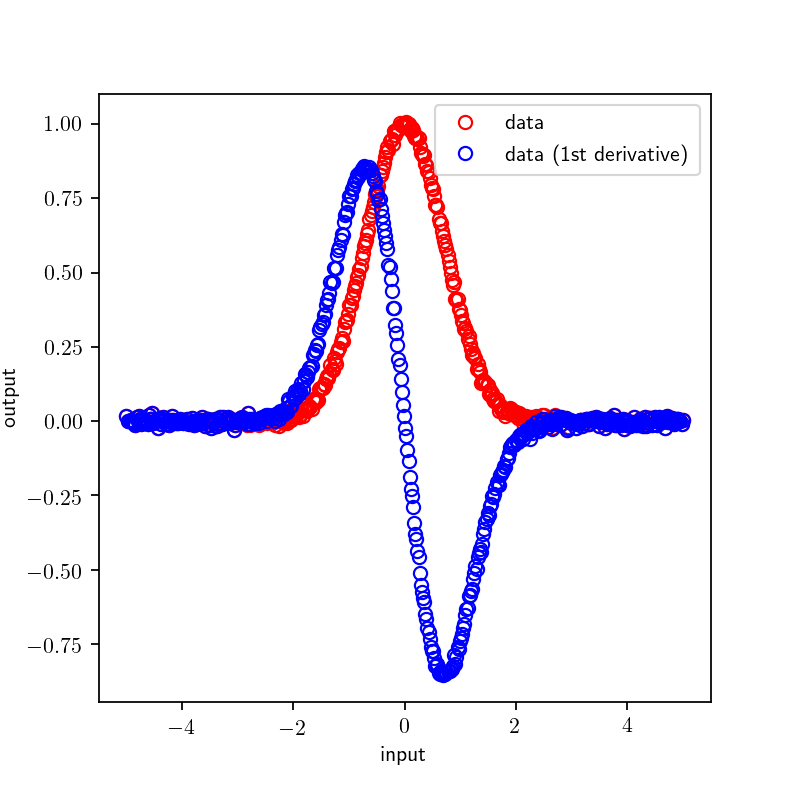

In [2]:
x = np.linspace(-5,5,500)
x_pred = np.linspace(1.5*x[0],1.5*x[-1],x.shape[0])
epsilon = stats.norm(loc=0,scale=0.01)
noise = epsilon.rvs(size=x.shape[0])
t_0 = np.exp(-x**2) + noise
t_1 = -2*x*np.exp(-x**2) + noise
t = np.hstack((t_0,t_1))

N = len(t_0)
N_pred = len(x_pred)

fig = plt.figure(figsize=(5,5))
plt.plot(x,t_0,'ro',markerfacecolor="None",label="data")
plt.plot(x,t_1,'bo',markerfacecolor="None",label="data (1st derivative)")
plt.xlabel("input")
plt.ylabel("output")
plt.legend(loc=0)
plt.show()

## 1. Single Regression

### 1.1 Linear Kernel

Neat now let's test whether we can regress that data using a polynomial feature space.

(1000, 6) (1000,)


<IPython.core.display.Javascript object>


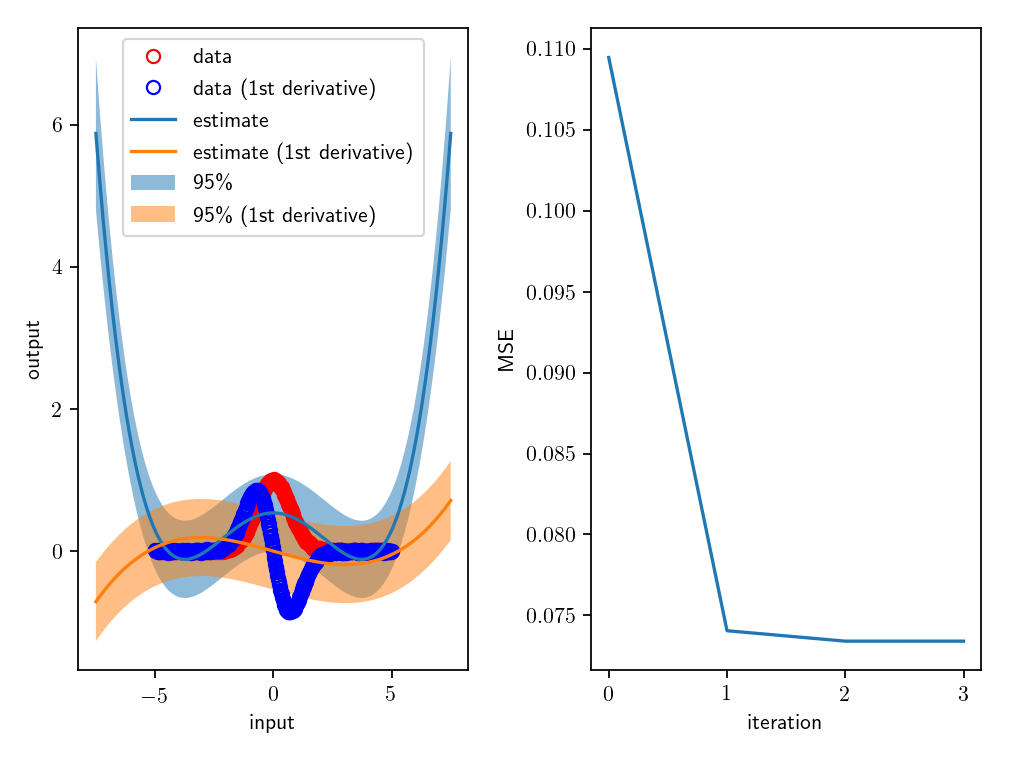

In [3]:
# choosing the feature space
k = 5
trafo = preprocessing.PolynomialFeatures(k)

X_0 = trafo.fit_transform(x.reshape((-1,1)))
trafo_der  = preprocessing.PolynomialFeatures(k-1)
X_1 = trafo_der.fit_transform(x.reshape((-1,1)))
X_1 = np.hstack((np.zeros((X_1.shape[0],1)),X_1))
X = np.vstack((X_0,X_1))
t = np.hstack((t_0,t_1))
print(X.shape,t.shape)

M = X.shape[1]

# initializing hyperparameters
init_beta = 1./ np.var(t) # (that's the default start)
init_alphas = np.ones(X.shape[1])
init_alphas[1:] = np.inf

# setting up the model regression class
model = RelevanceVectorMachine(n_iter=250,verbose=False,compute_score=True,init_beta=init_beta,
                               init_alphas=init_alphas)
# regress
model.fit(X,t)

# predict
X_pred_0 = trafo.fit_transform(x_pred.reshape((-1,1)))
X_pred_1 = trafo_der.fit_transform(x_pred.reshape((-1,1)))
X_pred_1 = np.hstack((np.zeros((X_pred_1.shape[0],1)),X_pred_1))
X_pred = np.vstack((X_pred_0,X_pred_1))

y, yerr = model.predict(X_pred,return_std=True)

y_0, y_1 = y[:N_pred], y[N_pred:]
yerr_0, yerr_1 = yerr[:N_pred], yerr[N_pred:]


fig = plt.figure()
ax = fig.add_subplot(121)
ax.plot(x,t_0,'ro',label="data",markerfacecolor="None")
ax.plot(x,t_1,'bo',label="data (1st derivative)",markerfacecolor="None")
ax.fill_between(x_pred,y_0-2*yerr_0,y_0+2*yerr_0,alpha=.5,label="95\%")
ax.fill_between(x_pred,y_1-2*yerr_1,y_1+2*yerr_1,alpha=.5,label="95\% (1st derivative)")
ax.plot(x_pred,y_0,'-',label="estimate")
ax.plot(x_pred,y_1,'-',label="estimate (1st derivative)")
plt.legend(loc=0)
ax.set_xlabel("input")
ax.set_ylabel("output")

ax1 = fig.add_subplot(122)
ax1.plot(model.mse_,'-')
ax1.set_xlabel("iteration")
ax1.set_ylabel("MSE")
plt.tight_layout()
plt.show()

### 1.2 Localized Kernel

Indeed that seemed to work. But what about a Gaussian feature space, will it be able to fit the Gaussian?

In [4]:
def dis_wrapper(dis,dx=1.,k_der=1):
    def _dis_wrapped(x):
        return misc.derivative(dis.pdf,x,dx=dx,n=k_der)
    return _dis_wrapped

class GaussianFeatures(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    """Generate Gaussian features.

    Generate a design matrix of k Gaussians starting at mu0, separated 
    by dmu all with the same scale.

    Parameters
    ----------
    k : int, optional, default 10
        The number of Gaussian.
    mu0 : float, optional, default 0
        The starting point for placing the first Gaussian.
    dmu : float, optional, default 1
        The increment to use separating the Gaussians.
    scale : float, optional, default 1
        The scale of all Gaussians.
    include_bias : boolean, optional, default True
        The design matrix includes a bias column if True.

    Example
    --------
    >>> x = np.linspace(-np.pi,np.pi,100)
    >>> trafo = GaussianFeatures(k=30,mu0=-3,dmu=.2)
    >>> X = trafo.fit_transform(x.reshape((-1,1)))
    
    """
    def __init__(self,k=10,mu0=0,dmu=1.,scale=1.,include_bias=True,k_der=0):
        self.k = k
        self.mu0 = mu0
        self.dmu = dmu
        self.scale = scale
        self.include_bias = include_bias
        self.k_der = k_der
        
    @staticmethod
    def _basis_functions(n_features, k, include_bias=True, mu0=0., dmu=.5, scale=1.,
                         k_der=0):
        """Generates a np.ndarray of Gaussian basis functions.

        Parameters
        ----------
        n_features : int
            number of features for each observation
        k : int
            number of basis functions
        include_bias : boolean, optional, default True
            whether or not to include a bias function (function that returns 1)
        mu0 : float, optional, default 0
            position of the first Gaussian
        dmu : float, optional, default .5
            increment to shift the Gaussians by
        scale : float, optional ,default 1
            scale of all Gaussians

        Returns
        -------
        basis : np.ndarray of callables of shape (k(+1),)
        """
        if k_der == 0:
            bias = np.array([lambda x: np.ones(x.shape[0])])
        else: # the bias is a constant for X_0 and therefore 0 for X_1
            bias = np.array([lambda x: np.zeros(x.shape[0])])
        G = np.array([dis_wrapper(stats.norm(loc=mu0+_k*dmu,scale=scale),k_der=k_der) for _k in range(k)])
        
        if include_bias:
            basis = np.concatenate((bias,G))
        else:
            basis = G
        return basis
        
    def fit(self,X,y=None):
        """Compute number of output features.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The data.

        Returns
        -------
        self : instance
        """
        n_samples, n_features = utils.check_array(X).shape
        self.n_input_features_ = n_features
        
        self.n_output_features_ = len(self._basis_functions(n_features,self.k, 
                                        self.include_bias, self.mu0, self.dmu, self.scale, k_der=self.k_der))
        return self
        
    
    def transform(self,X):
        """Applies the basis functions.

        Parameters
        ----------
        X : np.ndarray of shape (n_samples, n_input_features)

        Returns
        -------
        XP : np.ndarray of shape (n_samples, n_output_features)
            The design matrix.

        Note
        ----
        Requires prior execution of self.fit.
        """
        sklearn.utils.validation.check_is_fitted(self, ['n_input_features_', 'n_output_features_'])

        X = sklearn.utils.validation.check_array(X, dtype=sklearn.utils.validation.FLOAT_DTYPES)
        n_samples, n_features = X.shape

        if n_features != self.n_input_features_:
            raise ValueError("X shape does not match training shape")

        # allocate output data
        XP = np.empty((n_samples, self.n_output_features_), dtype=X.dtype)
        basis = self._basis_functions(self.n_input_features_, self.k, self.include_bias,
                                     self.mu0, self.dmu, self.scale, k_der=self.k_der)
        for i,b in enumerate(basis):
            XP[:,i] = b(X).ravel()
        return XP
    
    def fit_transform(self,X):
        """Calls fit and transform on X.
        """
        self.fit(X)
        return self.transform(X)

<IPython.core.display.Javascript object>


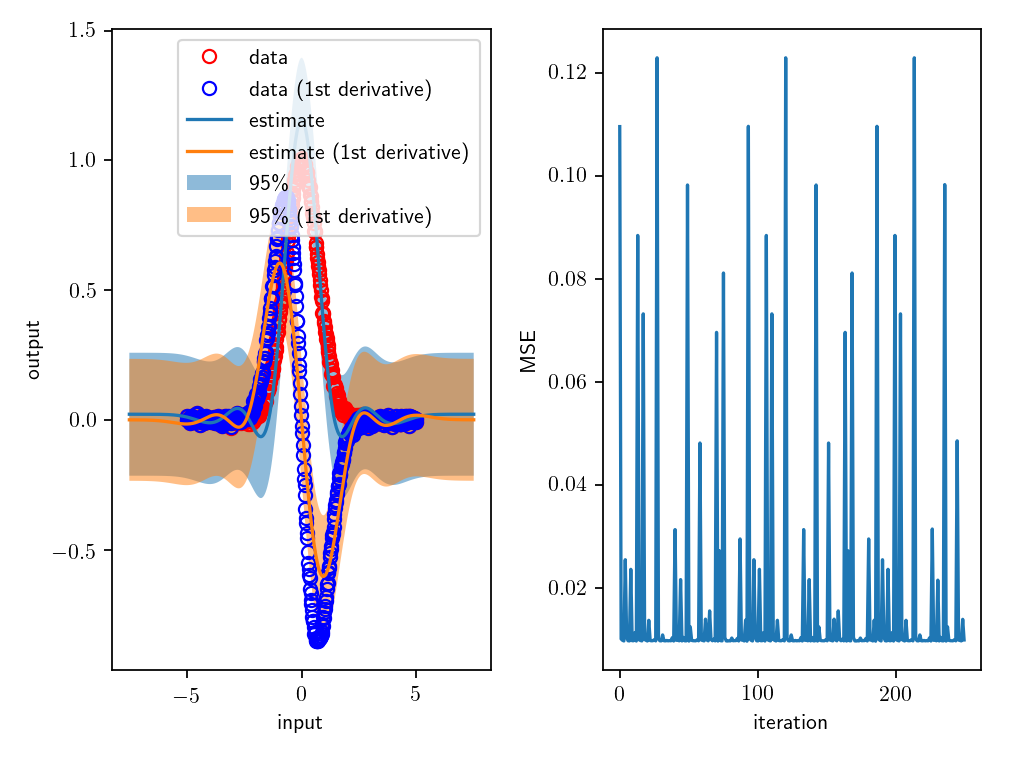

In [5]:
# choosing the feature space
trafo_0 = GaussianFeatures(k=30, mu0=-3, dmu=.2, k_der=0)
trafo_1 = GaussianFeatures(k=30, mu0=-3, dmu=.2, k_der=1)
X_0 = trafo_0.fit_transform(x.reshape((-1,1)))
X_1 = trafo_1.fit_transform(x.reshape((-1,1)))
X = np.vstack((X_0,X_1))

# initializing hyperparameters
init_beta = 1./ np.var(t) # (that's the default start)
init_alphas = np.ones(X.shape[1])
init_alphas[1:] = np.inf

# setting up the model regression class
model = RelevanceVectorMachine(n_iter=250,verbose=False,compute_score=True,init_beta=init_beta,
                               init_alphas=init_alphas,do_logbook=True,update_pct=1)

# regress
model.fit(X,t)

# predict
X_pred_0 = trafo_0.fit_transform(x_pred.reshape((-1,1)))
X_pred_1 = trafo_1.fit_transform(x_pred.reshape((-1,1)))
X_pred = np.vstack((X_pred_0,X_pred_1))

y, yerr = model.predict(X_pred, return_std=True)

y_0, y_1 = y[:N_pred], y[N_pred:]
yerr_0, yerr_1 = yerr[:N_pred], yerr[N_pred:]

fig = plt.figure()
ax = fig.add_subplot(121)
ax.plot(x,t_0,'ro',label="data",markerfacecolor="None")
ax.plot(x,t_1,'bo',label="data (1st derivative)",markerfacecolor="None")
ax.fill_between(x_pred,y_0-2*yerr_0,y_0+2*yerr_0,alpha=.5,label="95\%")
ax.fill_between(x_pred,y_1-2*yerr_1,y_1+2*yerr_1,alpha=.5,label="95\% (1st derivative)")
ax.plot(x_pred,y_0,'-',label="estimate")
ax.plot(x_pred,y_1,'-',label="estimate (1st derivative)")
plt.legend(loc=0)
ax.set_xlabel("input")
ax.set_ylabel("output")

ax1 = fig.add_subplot(122)
ax1.plot(model.mse_,'-')
ax1.set_xlabel("iteration")
ax1.set_ylabel("MSE")
plt.tight_layout()
plt.show()

## Repeated Regression

### 2.1 Localized kernel

<IPython.core.display.Javascript object>


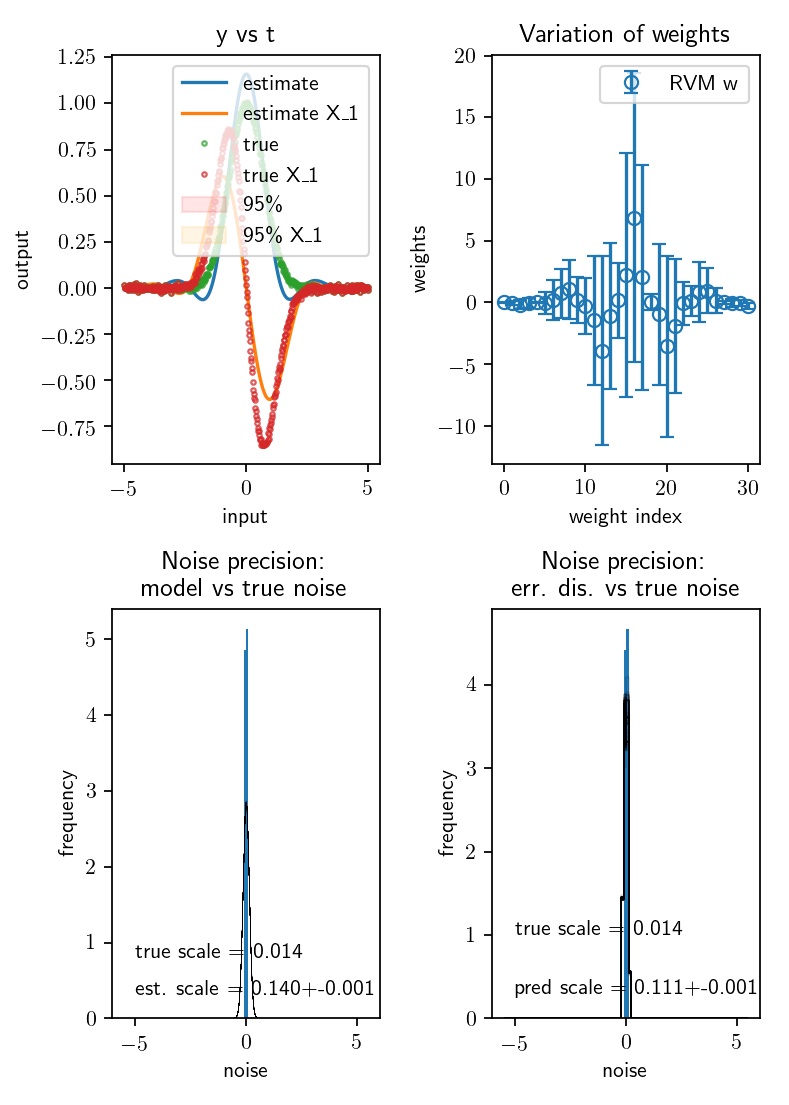

<IPython.core.display.Javascript object>


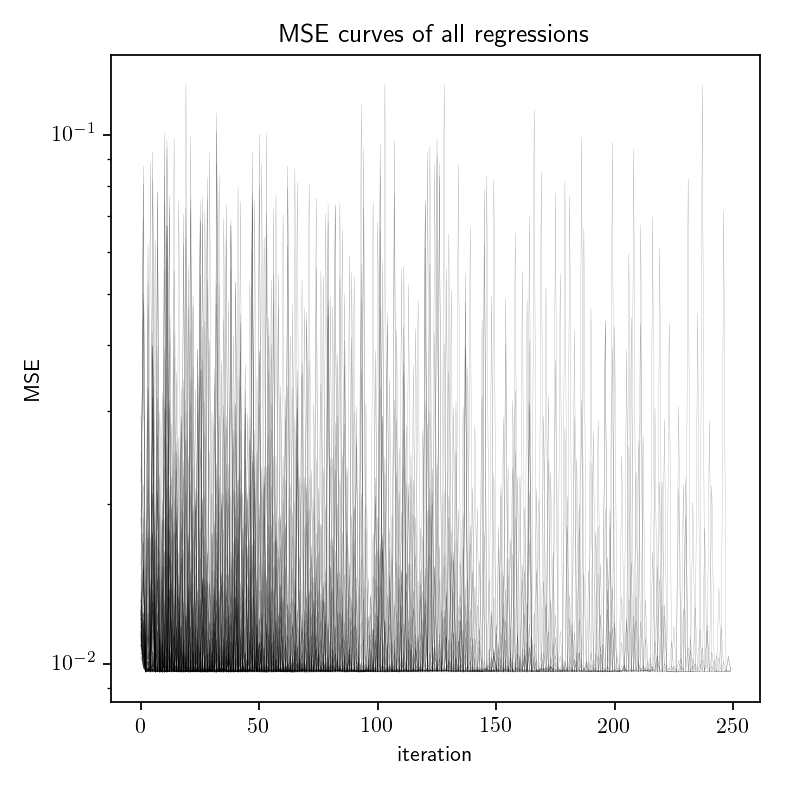

In [7]:
# choosing the feature space
trafo_0 = GaussianFeatures(k=30, mu0=-3, dmu=.2, k_der=0)
trafo_1 = GaussianFeatures(k=30, mu0=-3, dmu=.2, k_der=1)
base_trafo_0 = trafo_0.fit_transform
base_trafo_1 = trafo_1.fit_transform

# initializing hyperparameters using callable distributions giving new hyperparameters
# with every call (useful for repeated regression)
init_beta = distribution_wrapper(stats.halfnorm(scale=1),size=1,single=True)
init_alphas = distribution_wrapper(stats.halfnorm(scale=1),single=False)

model_type = RelevanceVectorMachine
model_kwargs = dict(n_iter=250,verbose=False,compute_score=True,init_beta=init_beta,
                       init_alphas=init_alphas,fit_intercept=False, update_pct=.9)

Nruns = 100
runtimes, coefs, models = repeated_regression(x, base_trafo_0, model_type, t=t,
                                              model_kwargs=model_kwargs, Nruns=Nruns,
                                              return_coefs=True, return_models=True,
                                              base_trafo_1=base_trafo_1)

X_0 = base_trafo_0(x.reshape((-1,1)))
X_1 = base_trafo_1(x.reshape((-1,1)))

plot_summary(models,noise,x,t,X_0,coefs,base_trafo_0,X_1=X_1)

Adding the derivatives to the regression process seems to increase the difficulty in finding the global minimum, since confidence intervals of the predicted functions do not completely overlap with the data everywhere. The weights are also much more uncertain and the noise levels seem to deviate by an order of magnitude. Hence there is either a bug or a fundamental issue. Interestingly enough the regression improves when limiting the number of basis functions which are allowed to be updated every iteration.